In [ ]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
drive.mount('/content/drive')
image_path = '/content/drive/My Drive/smai/coco_imgs.npy'
coco_imgs = np.load(image_path)
captions_path = '/content/drive/My Drive/smai/coco_captions.npy'
coco_captions = np.load(captions_path)

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 35.2 MB/s eta 0:00:00


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
print("1 done")
!unzip val2014.zip -d /content/
print("2 done")
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
print("3 done")
!unzip annotations_trainval2014.zip -d /content/
print("4 done")

Streaming output truncated to the last 5000 lines.
 extracting: /content/val2014/COCO_val2014_000000039656.jpg  
 extracting: /content/val2014/COCO_val2014_000000071667.jpg  
 extracting: /content/val2014/COCO_val2014_000000376046.jpg  
 extracting: /content/val2014/COCO_val2014_000000066394.jpg  
 extracting: /content/val2014/COCO_val2014_000000277584.jpg  
 extracting: /content/val2014/COCO_val2014_000000383518.jpg  
 extracting: /content/val2014/COCO_val2014_000000262466.jpg  
 extracting: /content/val2014/COCO_val2014_000000153055.jpg  
 extracting: /content/val2014/COCO_val2014_000000155312.jpg  
 extracting: /content/val2014/COCO_val2014_000000010440.jpg  
 extracting: /content/val2014/COCO_val2014_000000541108.jpg  
 extracting: /content/val2014/COCO_val2014_000000202503.jpg  
 extracting: /content/val2014/COCO_val2014_000000161308.jpg  
 extracting: /content/val2014/COCO_val2014_000000153013.jpg  
 extracting: /content/val2014/COCO_val2014_000000089924.jpg  
 extracting: /conte

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.84s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
caption_embeddings = coco_captions
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
image_embeddings = coco_imgs
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


### Performing K-nearest neighbour search using Faiss for each image

In [ ]:
def knn_search(image_embeddings, k=5, nlist=100):
    d = image_embeddings.shape[1]

    # Training the index
    quantizer = faiss.IndexFlatL2(d)   # quantizer used for training IVF index. reduces size of input vector
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    index.train(image_embeddings)
    index.add(image_embeddings)

    k_nearest = []

    for i in range(len(image_embeddings)):
        # print("index is", i)

        # Search for k + 1 nearest neighbors
        D, I = index.search(np.array([image_embeddings[i]]), k + 1)

        # Filter out the case where the index i matches any of the retrieved indices
        filtered_pairs = [(d, index) for d, index in zip(D.flatten(), I.flatten()) if index != i][:k]
        k_nearest.extend(filtered_pairs)

    # Reshape k_nearest
    k_nearest = np.array(k_nearest).reshape(len(image_embeddings), k, 2)
    return k_nearest


In [ ]:
k_val = 5

In [ ]:
k_nearest = knn_search(image_embeddings)
k_nearest.shape

(40504, 5, 2)

In [ ]:
def calculate_query_vector(k_nearest, image_embeddings, caption_embeddings, m = 5, k=k_val):
  num_images, embedding_size = image_embeddings.shape
  query_vectors = []
  m = 5

  for i in range(num_images):
    weighted_sum = 0

    # for k nearest-neighbours for each image
    for j in range(k):
      jth_nearest_image_dist = k_nearest[i][j][0]
      jth_nearest_image_index = int(k_nearest[i][j][1])

      normalized_distance = (jth_nearest_image_dist - np.min(k_nearest[i][j])) / (np.max(k_nearest[i][j]) - np.min(k_nearest[i][j]))
      cosine_similarity = 1 - normalized_distance

      cap_sum = 0
      for cap in caption_embeddings[jth_nearest_image_index]:
        cap_sum += cap
      
      # adding captions weighted by cosine similarity to the weighted sum
      weighted_sum += cap_sum*cosine_similarity
      
    weighted_sum =  weighted_sum // m
    weighted_sum = weighted_sum // num_images
    query_vectors.append(weighted_sum)

  return query_vectors


In [ ]:
query_vectors = calculate_query_vector(k_nearest, image_embeddings, caption_embeddings, k = 5)
query_vectors = np.array(query_vectors)
query_vectors.shape

(40504, 512)

In [ ]:
nearest_captions = []
dummy_captions = []
actual_image_index = 0

In [ ]:
k_nearest.shape

(40504, 5, 2)

In [ ]:
# for i in range(len(image_embeddings)):
#   print(f"index is {i}", end='\r')

#   query = query_vectors[i]
#   nearest_index = k_nearest[i][1]

#   cur_cap_arr = []

#   for j in range(5):
#     index = int(k_nearest[0][j][1])
#     for cap in caption_embeddings[index]:
#       cur_cap_arr.append(cap)

#   # finding most similar from the first 5k nearest captions

#   sim_arr = []

#   for iter in range(k_val * 5):

#     cur_cap = cur_cap_arr[iter]
#     cur_cap = cur_cap.reshape(-1,1)
#     query = query.reshape(-1,1)

#     sim = cosine_similarity(query, cur_cap)[0][0]
#     sim_arr.append(sim)

#   max_sim_index = np.argmax(sim_arr)

#   image_index = int((max_sim_index) // 5)
#   caption_index = int((max_sim_index) % 5)

#   actual_image_index = int(k_nearest[i][1][image_index])

#   nearest_captions.append(list(zip([actual_image_index], [caption_index])))
#   # nearest_captions.append(actual_image_index)


In [ ]:
actual_captions_list = []
predicted_captions_list = []

In [ ]:
for i in range(len(image_embeddings)):

    m = 5

    # print(f"index is {i}", end='\r')
    print("index is ", i)
    query = query_vectors[i]
    nearest_indices = k_nearest[i][:, 1]  # Use all indices for the current query

    cur_cap_arr = []

    for index in nearest_indices:
        index = int(index)
        cur_cap_arr.extend(caption_embeddings[index])

    sim_arr = cosine_similarity(query.reshape(1, -1), np.array(cur_cap_arr))
    max_sim_index = np.argmax(sim_arr)

    image_index = max_sim_index // m
    caption_index = max_sim_index % m

    actual_image_index = int(nearest_indices[image_index])

    dummy_captions.append([(actual_image_index, caption_index)])

    predicted_image_index, predicted_caption_index = dummy_captions[i][0][0], dummy_captions[i][0][1]
    predicted_image, predicted_caption = coco_dset[predicted_image_index]

    cap = predicted_caption[predicted_caption_index]
    actual_image, actual_captions = coco_dset[i]

    actual_captions_list.append(actual_captions)
    predicted_captions_list.append(cap)


Streaming output truncated to the last 5000 lines.
index is  35504
index is  35505
index is  35506
index is  35507
index is  35508
index is  35509
index is  35510
index is  35511
index is  35512
index is  35513
index is  35514
index is  35515
index is  35516
index is  35517
index is  35518
index is  35519
index is  35520
index is  35521
index is  35522
index is  35523
index is  35524
index is  35525
index is  35526
index is  35527
index is  35528
index is  35529
index is  35530
index is  35531
index is  35532
index is  35533
index is  35534
index is  35535
index is  35536
index is  35537
index is  35538
index is  35539
index is  35540
index is  35541
index is  35542
index is  35543
index is  35544
index is  35545
index is  35546
index is  35547
index is  35548
index is  35549
index is  35550
index is  35551
index is  35552
index is  35553
index is  35554
index is  35555
index is  35556
index is  35557
index is  35558
index is  35559
index is  35560
index is  35561
index is  35562
index

**Testing on a random index**

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[33015][0][0], dummy_captions[33015][0][1]

In [ ]:
actual_image, actual_caption = coco_dset[33015]

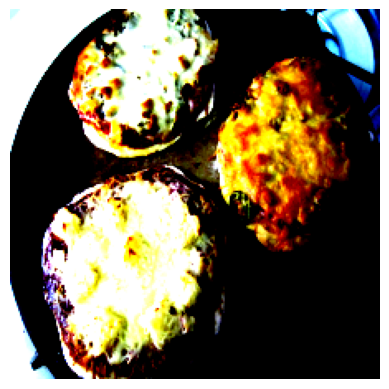

In [ ]:

image_np = actual_image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.axis('off')
plt.show()


In [ ]:
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]

In [ ]:
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['Three mini pizzas sitting on top of a metal pan.', 'three cooked dishes positioned on a wooden platter', 'Three types of food on a table ', 'Three cooked pizzas are on a pizza stone.', 'a big pan with three piazzas on it '] 
 PREDICTED CAPTION is
 Two pizzas sitting on top of metal racks.


**Example 2**

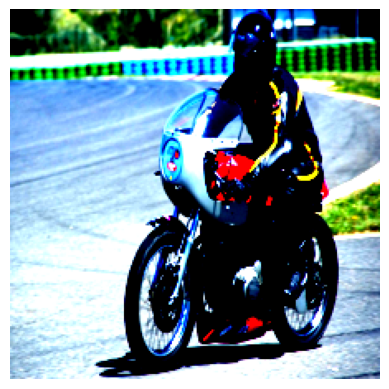

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[876][0][0], dummy_captions[876][0][1]
actual_image, actual_caption = coco_dset[876]

image_np = actual_image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.axis('off')
plt.show()


In [ ]:
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]

In [ ]:
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['a man wearing black is riding a red and silver motorcycle', 'A man is riding a motorcycle at a race track.', 'A person on a motorcycle dressed in an all black outfit with yellow stripes, riding on a road track.', 'A man riding a high performance racing bike on a track.', 'A man rides a motorcycle on a track.'] 
 PREDICTED CAPTION is
 A person on a motorcycle in a race.


**Example 3**

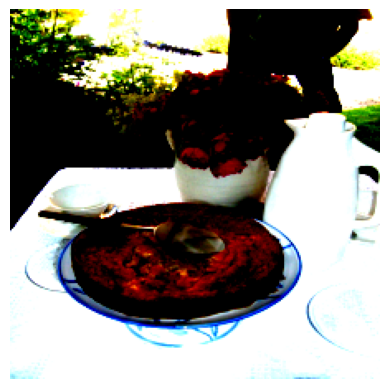

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[453][0][0], dummy_captions[453][0][1]
actual_image, actual_caption = coco_dset[453]

image_np = actual_image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]

In [ ]:
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['A cake on a pan with a spatula, a flower white with roses and a white beverage holder.', 'A table containing a cake and white pitcher.', 'Dessert set on a pedestal server with a spatula.', 'a close up of a cake on a plate on a table', 'A cake on a clear plate sitting on a table. '] 
 PREDICTED CAPTION is
 A partially eaten pastry is on a plate.


**Example 4**

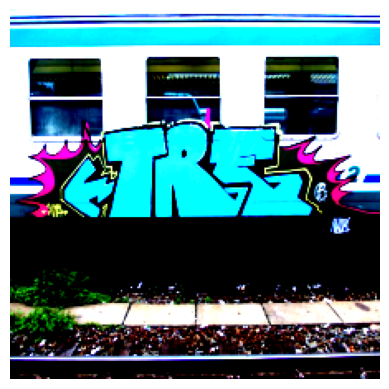

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[25694][0][0], dummy_captions[25694][0][1]
actual_image, actual_caption = coco_dset[25694]

image_np = actual_image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]

In [ ]:
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['A train covered in graffiti on top of train tracks.', 'A train car with art painted on its side ', 'Empty parked train painted with large, colorful graffiti.', 'The train car has been vandalized on the outside.', 'A large long train on a steel track.'] 
 PREDICTED CAPTION is
 A railroad train that has graffiti on the side of it


**Example 5**

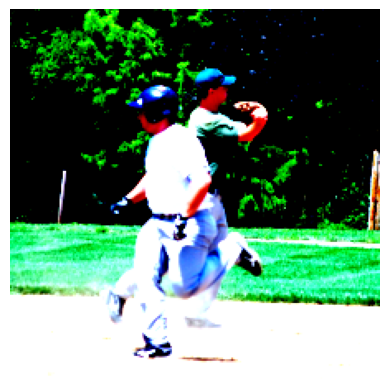

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[67][0][0], dummy_captions[67][0][1]
actual_image, actual_caption = coco_dset[67]

image_np = actual_image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]

In [ ]:
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['A couple of baseball player standing on a field.', 'Two men playing baseball in a field on a sunny day.', 'two baseball players are playing baseball on a field', 'A couple of men play baseball and the batter runs for base.', 'Two guys playing baseball, with trees in the back.'] 
 PREDICTED CAPTION is
 A couple of baseball players running a play during the game. 


In [ ]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    # lower_n_split = lambda x: x.lower().split()
    lower_n_split = lambda x: x.lower().split() if isinstance(x, str) else x


    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

# predict = ['a cup on a table', 'this music is bad']
# real = [['cup placed on a table', 'cup on a table', 'cup on a bench', 'a table', 'a cup'],
#         ['this music is bad','this is good music','good music','great songs','singing is great']]

print('accuracy_v2:', accuracy_v2(predicted_captions_list,actual_captions_list))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

accuracy_v2: 0.06866496908691067


***Observations***

1. Bleu Score comes out to be 0.069 when k = 5.

2. If we increase the value of k, we observe an increase in accuracy or bleu_score. This is because the k - closest distributed captions attained can be more varied and hence provide more options to compare with, increasing the probability of a better match

3. For a fixed k, I tried a few options from the faiss library to calculate k_nearest neighbours, of which *IndexFlatL2* and *IndexFlatIP* were decent yet slow. The current implementation uses a quantizer to implement two - level indexing and increase computation efficiency.

**FlatIndex**:

This is a basic index that performs a brute-force search. It is not optimized for efficiency but serves as a baseline.
Suitable for small datasets where the overhead of more complex structures is not justified.

**IndexFlatL2**:

This is a flat index designed for L2 (Euclidean) distance computations.
It performs a brute-force search, computing the exact Euclidean distance between the query vector and all vectors in the dataset.

**IndexFlatIP**:

IndexFlatIP:
This is a flat index designed for inner product (dot product) similarity computations.
Similar to IndexFlatL2, it performs a brute-force search, computing the exact inner product between the query vector and all vectors in the dataset.

**IVFFlat/IndexIVFScalarQuantizer**:

The Inverted File (IVF) structure with flat storage and scalar quantization. It is efficient for large-scale KNN search.
Scalar quantization reduces the dimensionality of the vectors for faster comparisons.

***Testing for k = 3***

In [ ]:
new_nearest = knn_search(image_embeddings, k=3)
new_nearest.shape

query_vectors = calculate_query_vector(k_nearest, image_embeddings, caption_embeddings, k = 3)
query_vectors = np.array(query_vectors)
query_vectors.shape

nearest_captions = []
dummy_captions = []

actual_image_index = 0


actual_captions_list = []
predicted_captions_list = []



In [ ]:
for i in range(len(image_embeddings)):

    # print(f"index is {i}", end='\r')
    print("index is ", i)
    query = query_vectors[i]
    nearest_indices = k_nearest[i][:, 1]  # Use all indices for the current query

    cur_cap_arr = []

    for index in nearest_indices:
        index = int(index)
        cur_cap_arr.extend(caption_embeddings[index])

    sim_arr = cosine_similarity(query.reshape(1, -1), np.array(cur_cap_arr))
    max_sim_index = np.argmax(sim_arr)

    image_index = max_sim_index // 5
    caption_index = max_sim_index % 5

    actual_image_index = int(nearest_indices[image_index])

    dummy_captions.append([(actual_image_index, caption_index)])

    predicted_image_index, predicted_caption_index = dummy_captions[i][0][0], dummy_captions[i][0][1]
    predicted_image, predicted_caption = coco_dset[predicted_image_index]

    cap = predicted_caption[predicted_caption_index]
    actual_image, actual_captions = coco_dset[i]

    actual_captions_list.append(actual_captions)
    predicted_captions_list.append(cap)


Streaming output truncated to the last 5000 lines.
index is  35504
index is  35505
index is  35506
index is  35507
index is  35508
index is  35509
index is  35510
index is  35511
index is  35512
index is  35513
index is  35514
index is  35515
index is  35516
index is  35517
index is  35518
index is  35519
index is  35520
index is  35521
index is  35522
index is  35523
index is  35524
index is  35525
index is  35526
index is  35527
index is  35528
index is  35529
index is  35530
index is  35531
index is  35532
index is  35533
index is  35534
index is  35535
index is  35536
index is  35537
index is  35538
index is  35539
index is  35540
index is  35541
index is  35542
index is  35543
index is  35544
index is  35545
index is  35546
index is  35547
index is  35548
index is  35549
index is  35550
index is  35551
index is  35552
index is  35553
index is  35554
index is  35555
index is  35556
index is  35557
index is  35558
index is  35559
index is  35560
index is  35561
index is  35562
index

In [ ]:
predicted_image_index, predicted_caption_index = dummy_captions[8796][0][0], dummy_captions[8796][0][1]
actual_image, actual_caption = coco_dset[8796]
predicted_image, predicted_caption = coco_dset[predicted_image_index]
cap = predicted_caption[predicted_caption_index]
print("ACTUAL CAPTION is: \n", actual_caption, "\n PREDICTED CAPTION is\n", cap)

ACTUAL CAPTION is: 
 ['Three mini pizzas sitting on top of a metal pan.', 'three cooked dishes positioned on a wooden platter', 'Three types of food on a table ', 'Three cooked pizzas are on a pizza stone.', 'a big pan with three piazzas on it '] 
 PREDICTED CAPTION is
 The kitchen includes a microwave on a refrigerator.


In [ ]:
print('accuracy when k = 3:', accuracy_v2(predicted_captions_list,actual_captions_list))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

accuracy_v2: 0.06798457615840214


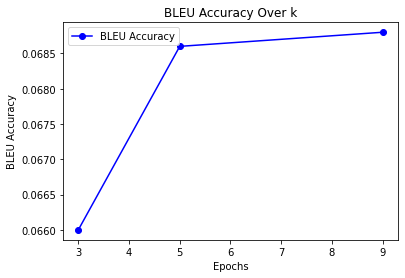

In [7]:
accuracy_arr = [0.0666, 0.0686, 0.0688]
import matplotlib.pyplot as plt

accuracy_arr = [0.066, 0.0686, 0.0688]
k = [3, 5, 9]

# Plotting the accuracy values
plt.plot(k, accuracy_arr, marker='o', linestyle='-', color='b', label='BLEU Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('BLEU Accuracy')
plt.title('BLEU Accuracy Over k')

# Adding a legend
plt.legend()

# Display the plot
plt.show()